# 第六週: 中文文集的情緒分析2

**Author:** 蔡睿澤<br>
**Date created:** 2023/03/22<br>
**Last modified:** 2023/03/27<br><br>
本週課程為「情緒分析2」，與情緒分析1不同，這次會使用中研院提供的CKIP自然語言處理工具包，但其中不像coreNLP有提供情緒分析套件，所以在此介紹一款用於中文情緒分析的套件SnowNLP，是Courpus-base的情緒分析，不是使用情緒字典，而是使用預訓練的情緒分析模型或演算法，給與整個文章一個情緒分數。情緒分析2的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中會介紹CKIP、分析方法、SnowNLP

## 大綱
1. 套件說明
2. CKIP 介紹
    + 2.1 安裝CKIP
    + 2.2 利用CKIP進行自然語言處理
3. CKIP 標註
    + 3.1 將抓取結果用CKIP進行處理
    + 3.2 探索分析 - NER
    + 3.3 探索分析 - POS
4. 利用SnowNLP進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- CKIP: 全名為Chinese Knowledge and Information Processing，中研院開發的中文自然語言處理工具。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [ ]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install ckiptagger[tf,gdown] wordcloud SnowNLP

In [3]:
# 確認當前工作目錄
#%pwd

'c:\\Users\\grace\\Desktop\\大四\\111-2\\社群媒體分析\\2nd 讀書會'

In [6]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

如果有重新裝package，記得需要restart kernel 才會使用更新後的套件

## 2. CKIP 介紹
- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

### 2.1 CKIP安裝

In [ ]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [3]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\grace\AppData\Local\Programs\Python\Python39\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\grace\AppData\Local\Programs\Python\Python39\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\grace\AppData\Local\Programs\Python\Python39\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by th

In [4]:
# 自定義辭典
word_to_weight = {
    "魔法覺醒": 1,
    "睽違已久": 2,
}
dictionary1 = construct_dictionary(word_to_weight)
print(dictionary1)

[(4, {'魔法覺醒': 1.0, '睽違已久': 2.0})]


In [5]:
sentence_list = [
    "哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app",
     "很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害"
]

word_sentence_list = ws(sentence_list, coerce_dictionary = dictionary1)  # 斷詞
pos_sentence_list = pos(word_sentence_list)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return
    
for i, sentence in enumerate(sentence_list):
    print()
    print(f"sentence {i}: {sentence}")
    print("\nPOS: ")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    print("\nNER: ")
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


sentence 0: 哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app

POS: 
哈利波特(Nb)　魔法覺醒(Nb)　是(SHI)　一(Neu)　個(Nf)　中國(Nc)　網易(Nb)　代理(VC)　的(DE)　粉絲(Na)　睽違已久(VH)　的(DE)　手遊(Na)　app(FW)　

NER: 
(11, 13, 'NORP', '中國')
(13, 15, 'ORG', '網易')

sentence 1: 很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害

POS: 
很多(Neqa)　人(Na)　滿心(D)　期待(VK)　這(Nep)　款(Nf)　英國(Nc)　出品(VC)　的(DE)　遊戲(Na)　，(COMMACATEGORY)　卻(D)　又(D)　害怕(VK)　受(VJ)　傷害(Na)　

NER: 
(9, 11, 'GPE', '英國')


## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)文章
+ 關鍵字:「吃到飽」(1630筆)
+ 時間: 2020-01-10 ~ 2022-12-31

我們已經介紹過CKIP的使用方式，現在來對PTT的資料使用CKIP進行自然語言處理

In [19]:
## 讀取文章
df = pd.read_csv('Tech_Job_OriginalData.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,各位年薪千萬的大大好，新年快樂。\n小弟是第一次發文的新鮮人\n目前研替面試一個段落\n拿到...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1514853292.A...,[新聞]【掙扎片】年薪百萬的科技人 卻因這幾點,2018-01-02 00:28:49,Angels5566,Tech_Job,有網友在mobile01分享，自己在科技業已工作9年，年薪約百萬，但最近老婆還是希望他\n去...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""latin0126"", ...",113.196.174.254,2018-04-27 12:51:21,ptt
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1515382875.A...,[徵才]高雄昇雷科技股份有限公司誠徵工程師,2018-01-08 03:35:11,qqgreenmoon,Tech_Job,【公司名稱】\n昇雷科技股份有限公司\n\n【工作職缺】\n1、硬體工程師\n2、系統工程師...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ohmypig"", ""c...",1.173.60.158,2018-04-27 12:51:21,ptt


定義文字清理的相關function

In [7]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 處理相關function

In [8]:
# 自定義辭典
with open('dict/user_dict.txt', encoding='utf-8') as f:    
    lines = f.read().splitlines()
dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'竹科': 500.0, '群暉': 500.0, 'VR': 500.0, '蝦皮': 500.0, '華碩': 500.0, '鴻海': 500.0}), (3, {'責任制': 500.0, '分公司': 500.0, '記憶體': 500.0, '演算法': 500.0, '機器人': 500.0, '富士康': 500.0, 'HTC': 500.0, '台達電': 500.0, '宏達電': 500.0, '聯發科': 500.0}), (4, {'年金改革': 500.0, '結婚禮金': 500.0, '生育津貼': 500.0, '教育訓練': 500.0, '資訊工程': 500.0, '華電聯網': 500.0, '外包人員': 500.0, '金融風暴': 500.0, '專題內容': 500.0, '學科理論': 500.0, '組織架構': 500.0, '產品經理': 500.0, '專案經理': 500.0, '中華電信': 500.0}), (5, {'研發工程師': 500.0, '團體意外險': 500.0, '軟體工程師': 500.0, '天線工程師': 500.0, '系統工程師': 500.0, '硬體工程師': 500.0, '化學工程師': 500.0, '台灣大哥大': 500.0}), (7, {'類比ic工程師': 500.0, 'Mozilla': 500.0})]


In [9]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [50]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['各位年薪千萬的大大好，新年快樂'], ['小弟是第次發文的新鮮人'], ['目前研替面試個段落'], ['拿到以下幾家豬屎屋的'], ['想請各位提供意見以供小弟參考']]
['各位年薪千萬的大大好，新年快樂', '小弟是第次發文的新鮮人', '目前研替面試個段落', '拿到以下幾家豬屎屋的', '想請各位提供意見以供小弟參考']


In [51]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 3336.5328965187073


+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [52]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,各位,Nh
1,1,年薪,Na
2,1,千萬,Neu
3,1,的,DE
4,1,大大,VH


In [53]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,千萬,CARDINAL
1,1,新年,DATE
2,1,第次,ORDINAL
3,1,幾,CARDINAL
4,1,高雄人電機,ORG


In [54]:
sentence_table.head()

,system_id,sentence
0,1,各位年薪千萬的大大好，新年快樂
1,1,小弟是第次發文的新鮮人
2,1,目前研替面試個段落
3,1,拿到以下幾家豬屎屋的
4,1,想請各位提供意見以供小弟參考


In [10]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1688篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1608篇有抓到ner

NameError: name 'pos_table' is not defined

In [56]:
# 將文章存成csv
pos_table.to_csv('raw_data/pos_table_OriginalData.csv', index = False)
entity_table.to_csv('raw_data/entity_table_OriginalData.csv', index = False)
sentence_table.to_csv('raw_data/sentence_table_OriginalData.csv', index = False)

### 3.2 探索分析 - NER

將剛才分析的資料匯入

In [11]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table_OriginalData.csv") 
entity_table = pd.read_csv("raw_data/entity_table_OriginalData.csv") 
sentence_table = pd.read_csv("raw_data/sentence_table_OriginalData.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [12]:
entity_table['ner'].unique()

array(['CARDINAL', 'DATE', 'ORDINAL', 'ORG', 'GPE', 'FAC', 'LOC',
       'PERSON', 'TIME', 'LAW', 'MONEY', 'NORP', 'PRODUCT', 'QUANTITY',
       'LANGUAGE', 'EVENT', 'WORK_OF_ART', 'PERCENT'], dtype=object)

In [14]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
11,ORG,8668
4,GPE,6429
1,DATE,5835
13,PERSON,3836
0,CARDINAL,3323
8,MONEY,1254
10,ORDINAL,1014
5,LANGUAGE,958


C:\Users\grace\AppData\Local\Temp\ipykernel_20968\1824814392.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


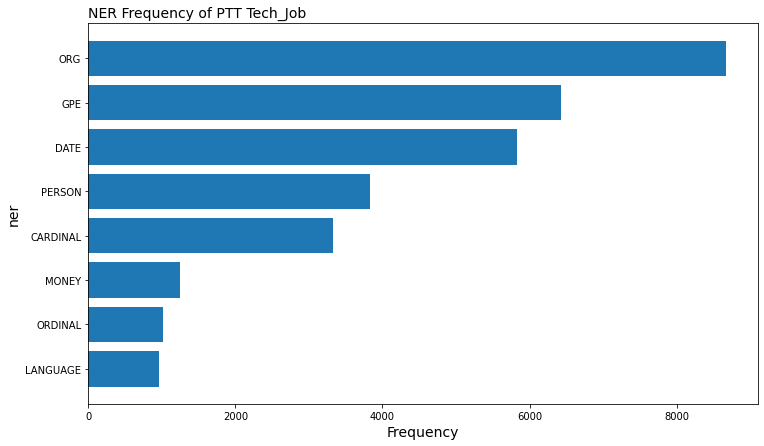

In [16]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Tech_Job',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

推論 : 因為是在科技求職版，經常會提到許多不同的公司。

### 涉及到的人名(PERSON)

C:\Users\grace\AppData\Local\Temp\ipykernel_20968\3272611795.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


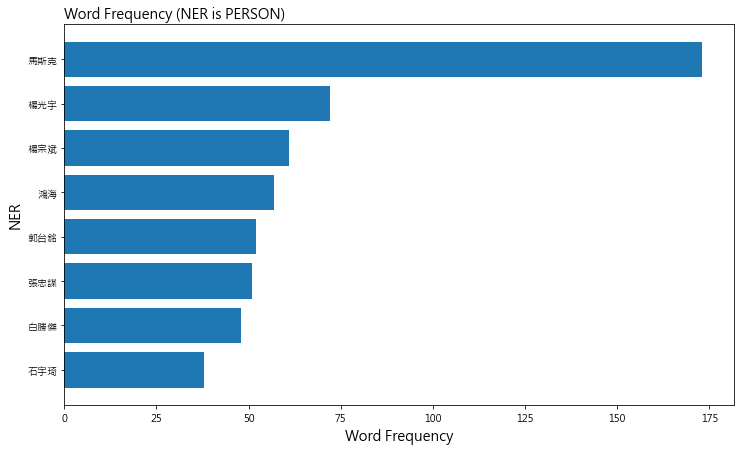

In [17]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
word = ner_count['word']
count = ner_count['count']


fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### PERSON 結果

從結果可以看到在科技業求職版中最常出現的PERSON類別是馬斯克，其次是楊光宇、楊宗斌。

Elon Musk是知名的企業家和科技人物，創辦了多家知名公司，例如特斯拉汽車、太空探索科技公司（SpaceX）等等。他的新聞和動向經常被關注和討論，因此出現在PTT科技業求職版的文章中非常合理。

[楊光宇相關新聞](https://technews.tw/2019/06/15/china-technology-spy-taiwan/)  
[楊宗斌是誰](https://www.google.com/search?q=%E7%A7%91%E6%8A%80%E6%A5%AD+%E6%A5%8A%E5%AE%97%E6%96%8C+ptt&sxsrf=APwXEddBcOlLVWChApv9nHe9a64tvWHM0Q%3A1681116019184&ei=c8szZLHsCq_l2roPqMSc-AU&ved=0ahUKEwjx8ZiZ9Z7-AhWvslYBHSgiB18Q4dUDCA8&uact=5&oq=%E7%A7%91%E6%8A%80%E6%A5%AD+%E6%A5%8A%E5%AE%97%E6%96%8C+ptt&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCAAQogQyBQgAEKIEMgUIABCiBDoHCCMQ6gIQJzoNCC4QxwEQrwEQ6gIQJzoFCAAQgAQ6CAgAEIAEELEDOgUILhCABDoLCC4QgAQQxwEQrwE6CAguEIAEEOoEOg4ILhCABBCxAxDHARCvAToRCC4QgAQQsQMQgwEQxwEQ0QM6CwgAEIAEELEDEIMBOggILhCABBCxAzoHCAAQGBCABDoUCC4QgAQQsQMQgwEQxwEQ0QMQ6gQ6EQguEIAEELEDEIMBEMcBEK8BOgQIABADOggIABCKBRCxAzoLCAAQigUQsQMQgwE6BQghEKABOggIABCJBRCiBEoECEEYAFD4CFi3J2DRKWgBcAB4AIABXogBywuSAQIyNZgBAKABAbABCsABAQ&sclient=gws-wiz-serp)

延伸討論 : 在整個文集中，楊光宇被提及的次數非常高，但是僅在3篇貼文中被頻繁地提及，因此我們得到這些分析結果之後要更仔細去檢查他的普遍性。

### 涉及到的組織(ORG)

C:\Users\grace\AppData\Local\Temp\ipykernel_25604\1011022482.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


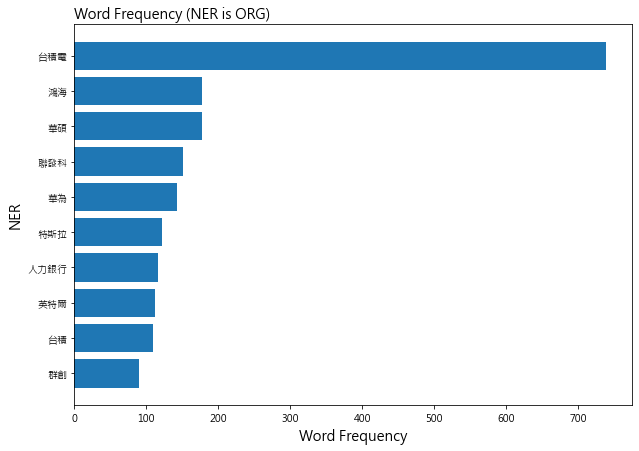

In [67]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### ORG 結果

結果顯示台積電是最常出現的組織，可能有以下含意：
1. 台積電是這個行業中非常有影響力的公司，很多人都希望能夠在這家公司工作，因此在求職相關的文章中，台積電會被頻繁提到。
2. 台積電是一家知名的公司，能夠為求職者提供很好的發展機會和福利待遇，因此吸引了很多人前來應聘。
3. 台積電在行業中處於領先地位，因此求職者希望能夠進入這家公司，從中學習和成長，為自己的職業生涯打下基礎。

推論 : 台積電在科技產業中的地位和影響力非常大，也可能顯示出求職者對這家公司的青睞程度高。

### 涉及到的民族、宗教、政治團體(NORP)

C:\Users\grace\AppData\Local\Temp\ipykernel_25604\1063220245.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


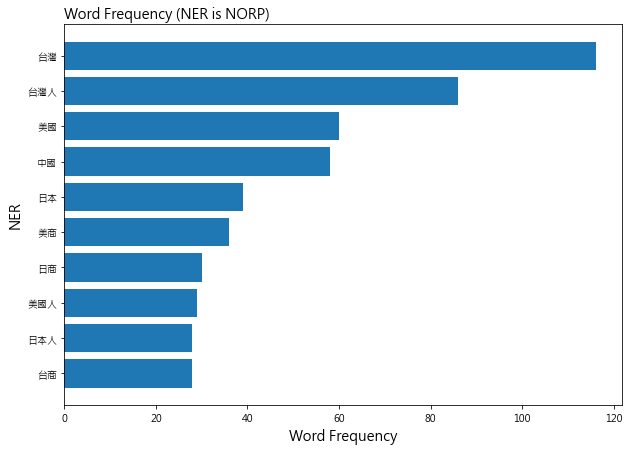

In [68]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [20]:
keyword_list = ['台積電']
yang_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{yang_selected.shape[0]}篇相關貼文")
yang_selected.head(3)

台積電：188篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
24,25,https://www.ptt.cc/bbs/Tech_Job/M.1518598511.A...,Re:[聘書]offer請益(長春/康寧/群創/工研院),2018-02-14 08:49:08,eros01,Tech_Job,看到長春 黑一下。\n1. 輪班問題~長春非常人治。\n 1.1 基本上，不同單位會由某...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""EMU1000"", ""c...",119.77.145.117,2018-05-17 10:40:53,ptt
36,37,https://www.ptt.cc/bbs/Tech_Job/M.1520165086.A...,[新聞]新鮮人最想進的公司:誠品、台積電、富邦,2018-03-04 11:58:43,LinuxKernel,Tech_Job,台大今天舉辦校園徵才，根據yes123求職網調查，畢業生夢幻企業！台積電、富邦金5連\n霸，...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""iouhsu"", ""cm...",1.169.102.36,2018-05-17 10:42:04,ptt
41,42,https://www.ptt.cc/bbs/Tech_Job/M.1520399680.A...,[新聞]文組生跨領域踏入科技業靠好英文勇闖台,2018-03-07 05:08:37,howard6066,Tech_Job,文組生跨領域踏入科技業 靠好英文勇闖台積電當歐美業務\nhttps://www.busine...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ruthertw"", ""...",59.124.97.2,2018-05-17 10:42:04,ptt


### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [87]:
pos_table['pos'].unique()

array(['Nh', 'Na', 'Neu', 'DE', 'VH', 'COMMACATEGORY', 'Nd', 'SHI', 'Nf',
       'VC', 'Ncd', 'VE', 'VF', 'VD', 'Cbb', 'VA', 'D', 'Da', 'Nc', 'P',
       'Nb', 'VG', 'V_2', 'VJ', 'VK', 'VCL', 'A', 'Caa', 'Nes', 'VB',
       'Nep', 'Dfa', 'VL', 'Neqa', 'Ng', 'T', 'VHC', 'FW', 'Di', 'Cab',
       'Nv', 'VI', 'DM', 'I', 'Neqb', 'Dk', 'Cba', 'Dfb', 'VAC',
       'COLONCATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY',
       'ETCCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [71]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
16,Na,148279
5,D,72289
36,VC,54336
42,VH,38174
6,DE,31022
18,Nc,30048
30,P,27113
39,VE,21169
28,Nh,20226
26,Nf,18138


C:\Users\grace\AppData\Local\Temp\ipykernel_25604\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


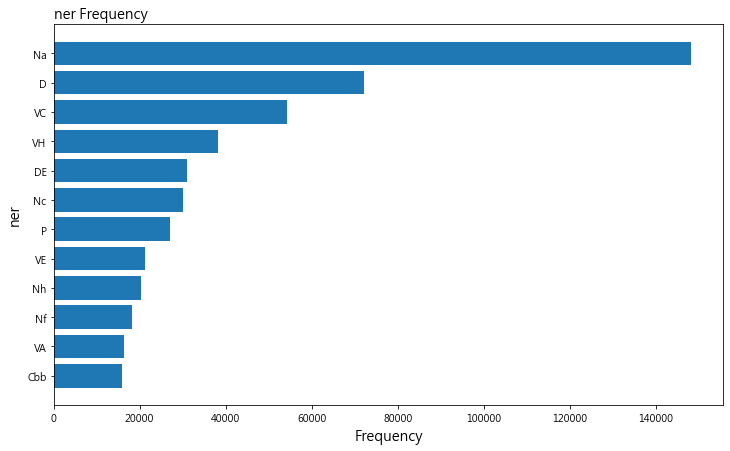

In [72]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### POS 常見詞性列表
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Noun)
+ 我們可以找出談論科技業求職的時候大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [73]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
417,台積電,876
2869,鴻海,350
2164,華碩,203
2049,聯發科,181
2809,馬斯克,179
1977,美光,162
411,台積,159
2160,華為,157
2844,高通,137
1662,特斯拉,134


最常討論到的名詞就跟上面的NER分析結果一致，可以看到都是組織名稱，最多的是台積電。

C:\Users\grace\AppData\Local\Temp\ipykernel_25604\1614676684.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


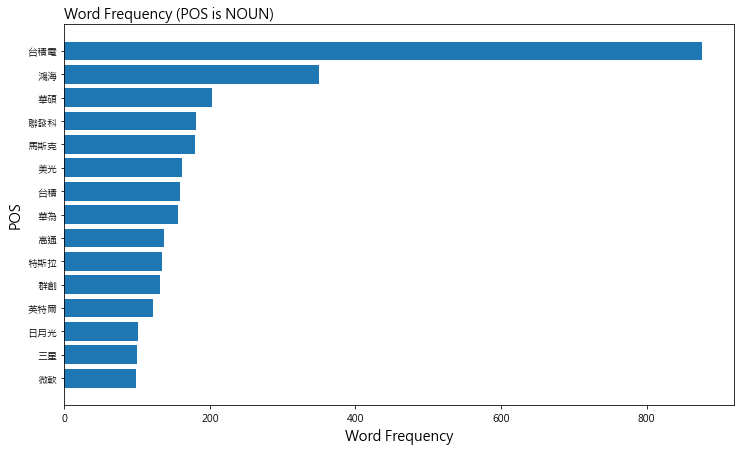

In [74]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到台積電依舊是壓倒性地出現最多次的專有名詞，接著是鴻海、華碩、聯發科等知名科技業龍頭。

### 涉及到的動詞(VERB)
+ 我們可以找出談論科技業求職時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [75]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
3827,面試,3331
3026,裁員,1402
3552,進行,529
3730,開發,480
2562,研發,448
2472,發展,435
2272,準備,349
863,學習,349
3602,選擇,343
2062,服務,331


C:\Users\grace\AppData\Local\Temp\ipykernel_25604\3731725871.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


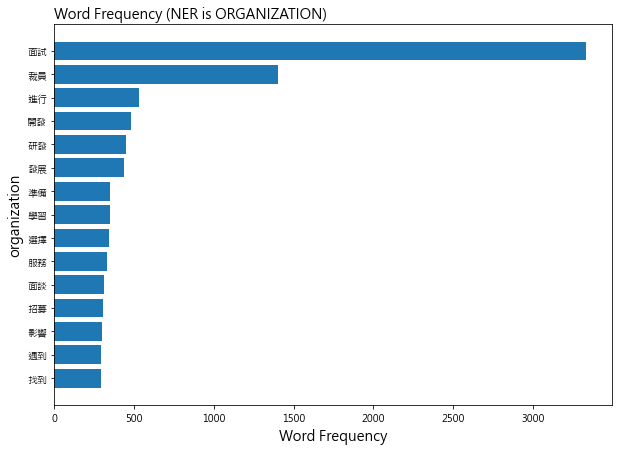

In [76]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is VERB)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「面試」佔了相當高的頻率，我們可以知道在科技業求職版中有許多面試的相關資訊，例如面試過程還有面試心得分享。
其次是「裁員」，在該討論版當中網友們也經常關注各家公司的裁員情況。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [23]:
from snownlp import SnowNLP
s = SnowNLP('文華訂位都訂不到')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.04180028804608915

使用先前NER得到的「台積電」相關文章，看看台積電相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [21]:
sentence_table = pd.read_csv("raw_data/sentence_table_OriginalData.csv") #匯資料

sentiment_date = pd.merge(sentence_table,yang_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
1063,25,看到長春黑下,2018-02-14 08:49:08,ptt
1064,25,輪班問題~長春非常人治,2018-02-14 08:49:08,ptt
1065,25,基本上，不同單位會由某位大主管塑造種組織文化或氣氛,2018-02-14 08:49:08,ptt
1066,25,基本上人事，是做門面，基本上到底工作內容如何，都是到了,2018-02-14 08:49:08,ptt
1067,25,單位，讓單位說了算了,2018-02-14 08:49:08,ptt


In [24]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
1063,25,看到長春黑下,2018-02-14 08:49:08,ptt,0.621226
1064,25,輪班問題~長春非常人治,2018-02-14 08:49:08,ptt,0.299673
1065,25,基本上，不同單位會由某位大主管塑造種組織文化或氣氛,2018-02-14 08:49:08,ptt,0.036281
1066,25,基本上人事，是做門面，基本上到底工作內容如何，都是到了,2018-02-14 08:49:08,ptt,0.599656
1067,25,單位，讓單位說了算了,2018-02-14 08:49:08,ptt,0.342639


In [25]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.030100e+04
mean     3.907325e-01
std      3.378557e-01
min      5.619483e-11
25%      6.035654e-02
50%      3.251433e-01
75%      6.711348e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

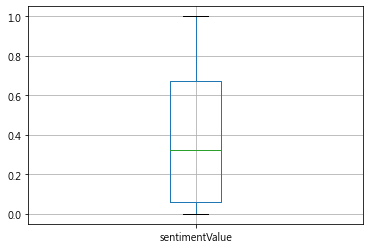

In [26]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [30]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
# sentiment_count.head()
print(sentiment_count.max())
print(sentiment_count.min())

artDate            2022-12
sentimentValue    0.567695
dtype: object
artDate            2018-02
sentimentValue    0.254364
dtype: object


C:\Users\grace\AppData\Local\Temp\ipykernel_20968\3287014777.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


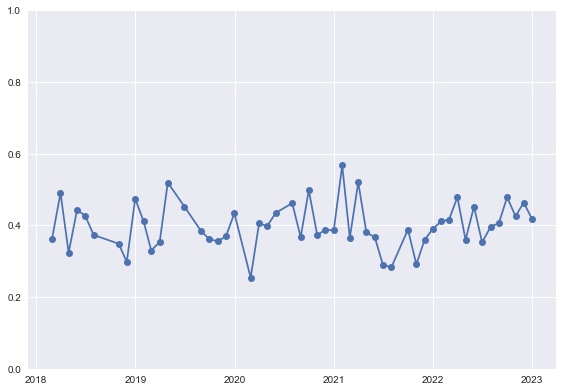

In [32]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.3~0.5之間，整體分數中間偏低一點。我們挑出分數看起來最低的 2018年2月 來分析。

### 詞彙探索
從上圖中可以發現 2020年2月 的情緒分數相對低，我們把這個月的負面句子挑出來看看他們都用甚麼詞。

In [33]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2018-02']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
1064,25,輪班問題~長春非常人治,2018-02,ptt,0.299673
1065,25,基本上，不同單位會由某位大主管塑造種組織文化或氣氛,2018-02,ptt,0.036281
1067,25,單位，讓單位說了算了,2018-02,ptt,0.342639
1068,25,有時感慨，如果有像我同學在台塑，雖然規定要去大陸，但是,2018-02,ptt,0.117691
1069,25,每人輪流年，回來就是準備升主辦，很大程度就克服內部矛盾,2018-02,ptt,0.072309


In [34]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,25,0.299673,看到
1,25,0.299673,長春
2,25,0.299673,黑下
3,25,0.299673,輪班
4,25,0.299673,問題


In [35]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 負面詞彙文字雲

In [36]:
# 自定停用字
with open('dict/stopwords.txt', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

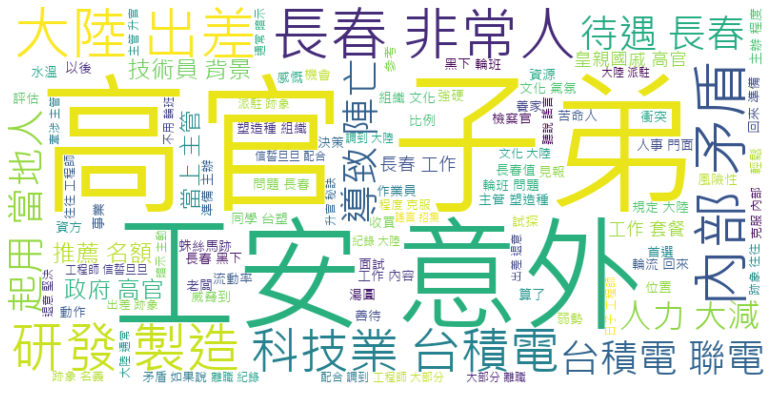

In [37]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'font/msjh.ttc'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()